# Семинар 3. Обучение сверточных нейросетей в Pytorch

На этом семинаре мы будем обучать LeNet-5 на данных MNIST (и не только :). Мы наконец перестанем реализовывать все самостоятельно и будем пользоваться готовым функционалом pytorch.

Для начала ознакомимся с парой примеров обучения модели:
* [Пример 1](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py)
* [Пример 2](https://github.com/jcjohnson/pytorch-examples/blob/master/nn/two_layer_net_nn.py)

In [0]:
in_google_collab = True

In [0]:
if in_google_collab:
    # http://pytorch.org/
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
  
    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
  
    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
    import torch

### Загрузка данных в pytorch

In [0]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import torch.utils.data

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
use_cuda = True

В этот раз мы будем работать MNIST: он отличается от digits разрещением изображений (28x28 вместо 8x8) и числом объектов (60000 в обучении вместо 1797). 

В pytorch есть своя обертка, позволяющая скачивать MNIST, но нам будет удобнее скачать его самостоятельно.

In [6]:
if in_google_collab:
  
  from google.colab import files
  
  uploaded = files.upload()

Saving util.py to util.py


In [0]:
from util import load_mnist

In [9]:
X_train, y_train, X_test, y_test = load_mnist()

Помимо обучающей и контрольной, нам понадобится валидационная выборка, чтобы настраивать гиперпараметры. Ее можно отделить от обучающей выборки (например, 25% = 15000 объектов). Однако модель несколько долго обучается даже на 75% обучающей выборки (несколько минут), что не очень хорошо для семинара. Поэтому для валидационных целей предлагается обучающую выборку также сжать до 15000 объектов. Финальную модель будем обучать по всей выборке.

In [55]:
from sklearn.model_selection import train_test_split

# shuffle data
np.random.seed(0)
idxs = np.random.permutation(np.arange(X_train.shape[0]))
X_train, y_train = X_train[idxs], y_train[idxs]
                            
X_train.shape

(60000, 1, 28, 28)

В pytorch есть удобный класс для генерации батчей - DataLoader. Ему на вход надо подать объект класса TensorDataset, слудащий оберткой над матрицами данных.

In [0]:
def get_loader(X, y, batch_size=64):
    train = torch.utils.data.TensorDataset(torch.from_numpy(X).float(), 
                                       torch.from_numpy(y))
    train_loader = torch.utils.data.DataLoader(train, 
                                               batch_size=batch_size)
    return train_loader

# for final model:
train_loader_full = get_loader(X_train, y_train) 
test_loader = get_loader(X_test, y_test)
# for validation purposes:
train_loader = get_loader(X_train[:15000], y_train[:15000])
val_loader = get_loader(X_train[15000:30000], y_train[15000:30000])

In [57]:
# check number of objects
val_loader.dataset.data_tensor.shape

torch.Size([15000, 1, 28, 28])

### Задание модели LeNet-5

Сверточный слой (из презентации Антона Осокина):
![Слайд про свертки из презентации Антона Осокина](https://github.com/nadiinchi/dl_labs/raw/master/convolution.png)

Нам надо реализовать LeNet-5:

![Архитектура LeNet-5](https://cdnpythonmachinelearning.azureedge.net/wp-content/uploads/2017/09/lenet-5-825x285.png?x64257)

Соберите нейросеть в соответствии с изображениями и примерами кода, которые были даны выше. В качестве нелинейности используйте ReLU (после всех сверточных и полносвязных слоев). Кроме того, нейросеть должна поддерживать увеличение числа сверток во всех сверточных слоях в k раз.

In [0]:
class CNN(nn.Module):
    def __init__(self, k=1, fc_one=False):
        super(CNN, self).__init__()
        ### your code here: define layers
        self.fc_one = fc_one
        self.conv1 = nn.Conv2d(1, 6*k, 5)
        self.conv2 = nn.Conv2d(6*k, 16*k, 5)
        self.fc1 = nn.Linear(16*4*4*k, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        if self.fc_one:
            self.fc_one = nn.Linear(16*4*4*k, 10)
        

    def forward(self, x):
        ### your code here: transform x using layers
        if not self.fc_one:
            out = F.relu(self.conv1(x))
            out = F.max_pool2d(out, 2)
            out = F.relu(self.conv2(out))
            out = F.max_pool2d(out, 2)
            out = out.view(out.size(0), -1)
            out = F.relu(self.fc1(out))
            out = F.relu(self.fc2(out))
            out = self.fc3(out)
        else:
            out = F.relu(self.conv1(x))
            out = F.max_pool2d(out, 2)
            out = F.relu(self.conv2(out))
            out = F.max_pool2d(out, 2)
            out = out.view(out.size(0), -1)
            out = self.fc_one(out)
        return out

Посчитаем параметры нейросети:

In [0]:
cnn = CNN()

In [60]:
def count_parameters(model):
    return sum(param.data.numpy().size for param \
               in model.parameters() if param.requires_grad)

count_parameters(cnn)

44426

### Обучение нейросети

Определим функцию потерь:

In [0]:
criterion = nn.CrossEntropyLoss() # loss includes softmax

Во время обучения модели удобно контролировать качество и на обучении, и на контроле (валидации) - возникает дублирующий код. Поэтому мы вынесем в отдельную функцию оценку модели, и в отдельную функцию - эпоху обучения. Это позволит также честно оценивать значение критерия качества на всей обучающей выборке по окончании эпохи (а не усреднять значения на минибатчах).

В прототипах указано про train и eval mode: в нашем случае они не нужны (были бы нужны, если бы мы использовали дропаут или батч-нормализацию, к примеру). Но чтобы вы могли использовать этот код в будущем, лучше указывать переключение режима.

In [0]:
def train_epoch(model, optimizer, train_loader):
    """
    for each batch 
    performs forward and backward pass and parameters update 
    
    Input:
    model: instance of model (example defined above)
    optimizer: instance of optimizer (defined above)
    train_loader: instance of DataLoader
    
    Returns:
    nothing
    
    Do not forget to set net to train mode!
    """
    ### your code here
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available() and use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    

def evaluate_loss_acc(loader, model):
    """
    Evaluates loss and accuracy on the whole dataset
    
    Input:
    loader:  instance of DataLoader
    model: instance of model (examle defined above)
    
    Do not forget to set net to eval mode!
    """
    ### your code here
    model.eval()
    correct = 0
    total = 0
    for images, labels in loader:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available() and use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
    return criterion(outputs, labels), correct/total
    
    
    
def train(model, opt, train_loader, test_loader, n_epochs, print_mode=True):
    """
    Performs training of the model and prints progress
    
    Input:
    model: instance of model (example defined above)
    opt: instance of optimizer (defined above)
    train_loader: instance of DataLoader
    test_loader: instance of DataLoader (for evaluation)
    n_epochs: int
    
    Returns:
    4 lists: train_log, train_acc_log, val_log, val_acc_log
    with corresponding metrics per epoch
    """
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        train_epoch(model, opt, train_loader)
        train_loss, train_acc = evaluate_loss_acc(train_loader, model)
        val_loss, val_acc = evaluate_loss_acc(test_loader, model)

        train_log.append(train_loss)
        train_acc_log.append(train_acc)

        val_log.append(val_loss)
        val_acc_log.append(val_acc)

        if print_mode is True:
            print (('Epoch [%d/%d], Loss (train/test): %.4f/%.4f,'+\
                   ' Acc (train/test): %.4f/%.4f' )
                       %(epoch+1, n_epochs, \
                         train_loss, val_loss, train_acc, val_acc))
            
    return train_log, train_acc_log, val_log, val_acc_log

Обучите нейронную сеть, используя определенные функции. Установите learning_rate=0.001, число эпох - 20. В качестве test_loader используйте валидационную выборку.

In [0]:
if torch.cuda.is_available() and use_cuda:
    cnn.cuda()

In [64]:
### your code here
num_epochs = 20
learning_rate = 0.001
from torch.optim import Adam
opt = Adam(cnn.parameters(), learning_rate)
train_log, train_acc, val_log, val_acc_log = train(cnn, opt, train_loader, val_loader, num_epochs)

Epoch [1/20], Loss (train/test): 0.1212/0.1886, Acc (train/test): 0.9210/0.9192
Epoch [2/20], Loss (train/test): 0.0512/0.0818, Acc (train/test): 0.9455/0.9407
Epoch [3/20], Loss (train/test): 0.0338/0.0384, Acc (train/test): 0.9583/0.9541
Epoch [4/20], Loss (train/test): 0.0289/0.0291, Acc (train/test): 0.9687/0.9622
Epoch [5/20], Loss (train/test): 0.0226/0.0174, Acc (train/test): 0.9740/0.9650
Epoch [6/20], Loss (train/test): 0.0111/0.0095, Acc (train/test): 0.9792/0.9691
Epoch [7/20], Loss (train/test): 0.0042/0.0059, Acc (train/test): 0.9825/0.9711
Epoch [8/20], Loss (train/test): 0.0013/0.0048, Acc (train/test): 0.9834/0.9703
Epoch [9/20], Loss (train/test): 0.0007/0.0051, Acc (train/test): 0.9843/0.9707
Epoch [10/20], Loss (train/test): 0.0008/0.0057, Acc (train/test): 0.9849/0.9714
Epoch [11/20], Loss (train/test): 0.0010/0.0030, Acc (train/test): 0.9898/0.9749
Epoch [12/20], Loss (train/test): 0.0007/0.0023, Acc (train/test): 0.9907/0.9765
Epoch [13/20], Loss (train/test): 0.0

Визуализируем результат прохождения изображения через слои. Код ниже отрисовывает сетку изображений: первый столбец - изображения цифр, следующие 6 столбцов - результаты применения фильтров к ним. Чтобы им воспользоваться, сохраните в x переменную, храняющую батч из 10 изображений, в y - результат применения первого лчоя к x.

In [0]:
if use_cuda:
    cnn.cpu()

In [0]:
### your code here
x = Variable(torch.from_numpy(X_train[:10]))
y = cnn.conv1(x)

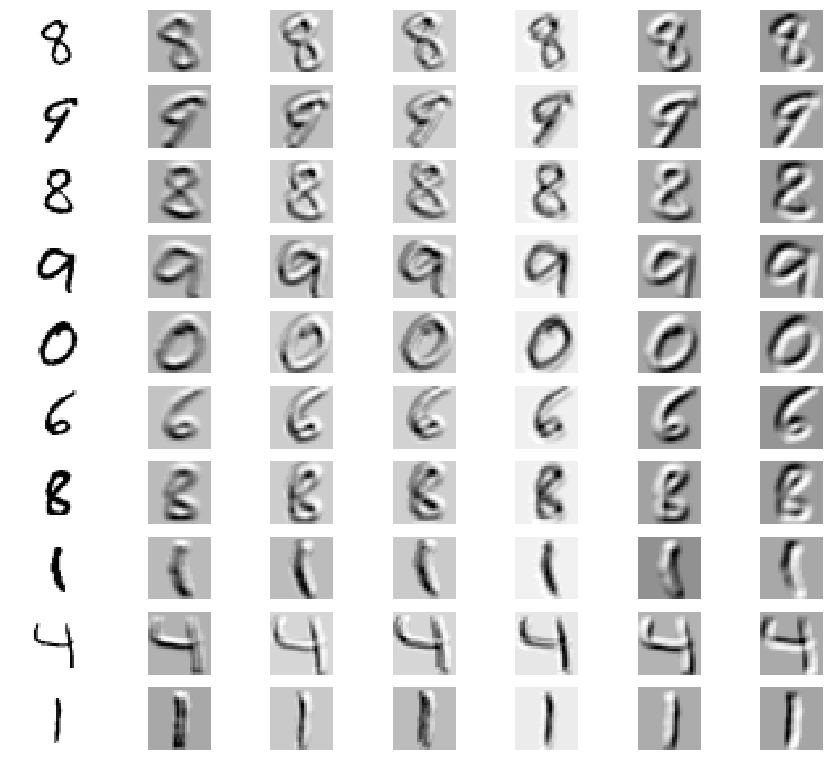

In [67]:
plt.figure(figsize=(15, 15))
for im in range(10):
    plt.subplot(11, 7, im*7+1)
    plt.imshow(x.data[im, 0])
    plt.axis("off")
    for i in range(6):
        plt.subplot(11, 7, im*7+i+2)
        plt.imshow(y.data[im, i].numpy())
        plt.axis("off")

Затем визуализируйте результат применения второго сверточного слоя (после всех предыдущих слоев):

In [0]:
### your code here
y_2 = cnn.conv2(y)

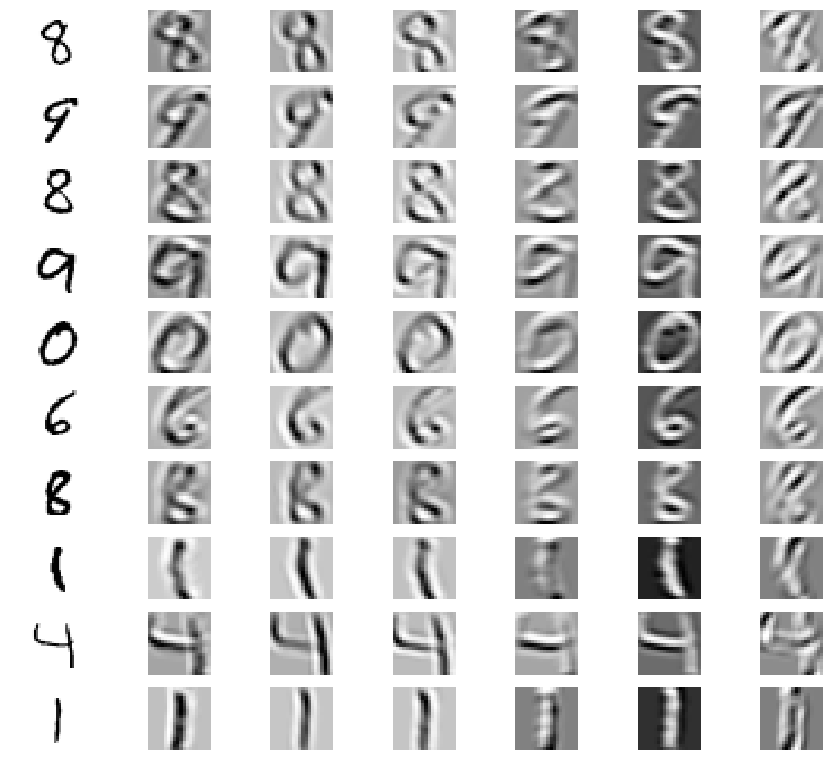

In [69]:
plt.figure(figsize=(15, 15))
for im in range(10):
    plt.subplot(11, 7, im*7+1)
    plt.imshow(x.data[im, 0])
    plt.axis("off")
    for i in range(6):
        plt.subplot(11, 7, im*7+i+2)
        plt.imshow(y_2.data[im, i].numpy())
        plt.axis("off")


### Подбор длины шага и размера батча

Постройте графики точности (accuracy) на обучающей и валидационной выборке в зависимости от номера эпохи при разных параметрах обучения: learning rate$ \in \{0.0001, 0.001, 0.01\}$, batch size $\in \{64, 256\}$. 

Лучше всего отображать кривые для обучения на левом графике, кривые для валидации - на правом с общей осью y (plt.ylim).

Как влияют длина шага и размер батча на итоговое качество?

In [0]:
### your code here
batch_sizes = {64, 256}
learning_rates = {0.0001, 0.001, 0.01}
num_epochs = 20
results = {}
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        train_loader = get_loader(X_train[:15000], y_train[:15000], batch_size=batch_size)
        val_loader = get_loader(X_train[15000:30000], y_train[15000:30000], batch_size=batch_size)
        cnn = CNN()
        if torch.cuda.is_available() and use_cuda:
            cnn.cuda()
        opt = Adam(cnn.parameters(), learning_rate)
        train_log, train_acc_log, val_log, val_acc_log = train(cnn, opt, train_loader, val_loader, num_epochs, print_mode=False)
        results["{}, {}".format(batch_size, learning_rate)] = (train_acc_log, val_acc_log)

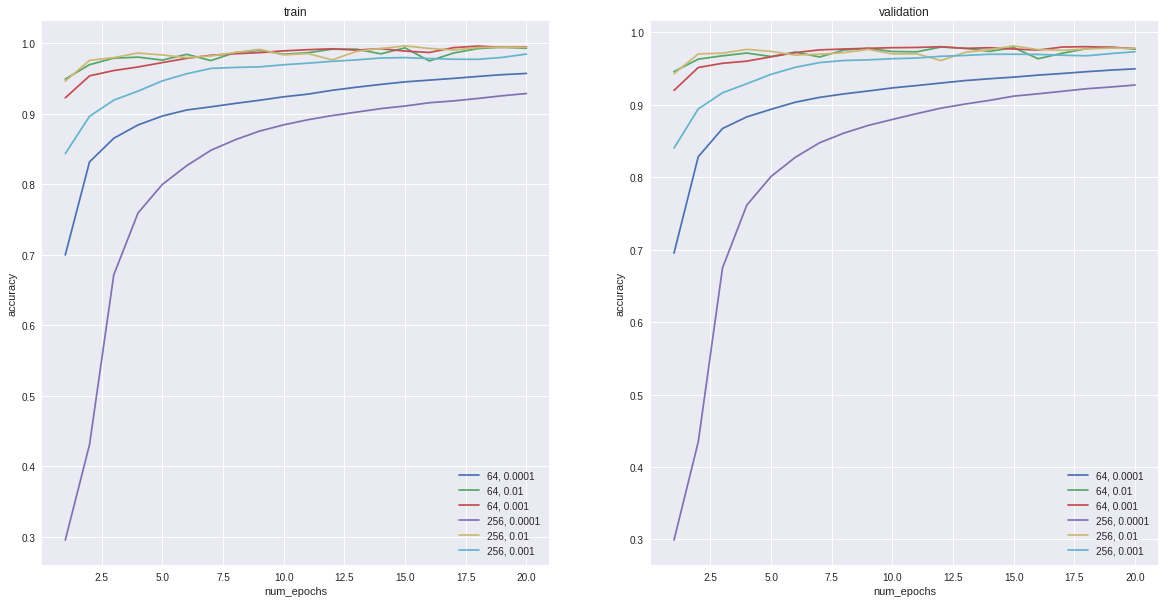

In [71]:
#plotting
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title('train')
ax[1].set_title('validation')
x = list(range(1, 21))
for i in range(len(ax)):
    ax[i].set_xlabel('num_epochs')
    ax[i].set_ylabel('accuracy')
    for key in results.keys():
        ax[i].plot(x, results[key][i])
        ax[i].legend(results.keys())

### Изменение архитектуры

Попробуйте модифицировать архитектуру нейросети: увеличить число фильтров и уменьшить число полносвязных слоев. 

Впишите цифры в скобки:
* LeNet-5 классич. (6 и 16 сверток):  качество на обучении: (0.987)  качество на валидации: (0.9739)
* Увеличение в 4 раза (24 и 64 сверток):  качество на обучении: (0.9955)  качество на валидации: (0.98)
* Удаление полносвзяного слоя: предыдущая нейросеть с 1 полносвязным слоем: качество на обучении: (0.9939)  качество на валидации: (0.9769)

In [72]:
### your code here
#LeNet-classic
cnn = CNN(k=1)
if torch.cuda.is_available() and use_cuda:
    cnn.cuda()
learning_rate = 0.001
batch_size = 64
num_epochs = 20
opt = Adam(cnn.parameters(), lr=learning_rate)
train_log, train_acc_log, val_log, val_acc_log = train(cnn, opt, train_loader, val_loader, num_epochs)

Epoch [1/20], Loss (train/test): 0.4160/0.4178, Acc (train/test): 0.8552/0.8539
Epoch [2/20], Loss (train/test): 0.2968/0.2935, Acc (train/test): 0.9063/0.9045
Epoch [3/20], Loss (train/test): 0.2091/0.2439, Acc (train/test): 0.9259/0.9255
Epoch [4/20], Loss (train/test): 0.1400/0.1994, Acc (train/test): 0.9452/0.9431
Epoch [5/20], Loss (train/test): 0.1015/0.1656, Acc (train/test): 0.9552/0.9522
Epoch [6/20], Loss (train/test): 0.0754/0.1470, Acc (train/test): 0.9609/0.9567
Epoch [7/20], Loss (train/test): 0.0580/0.1351, Acc (train/test): 0.9639/0.9606
Epoch [8/20], Loss (train/test): 0.0449/0.1283, Acc (train/test): 0.9674/0.9636
Epoch [9/20], Loss (train/test): 0.0373/0.1248, Acc (train/test): 0.9697/0.9653
Epoch [10/20], Loss (train/test): 0.0330/0.1167, Acc (train/test): 0.9715/0.9671
Epoch [11/20], Loss (train/test): 0.0309/0.1096, Acc (train/test): 0.9731/0.9687
Epoch [12/20], Loss (train/test): 0.0298/0.1049, Acc (train/test): 0.9734/0.9686
Epoch [13/20], Loss (train/test): 0.0

In [73]:
#LeNet-4x
cnn = CNN(k=4)
if torch.cuda.is_available() and use_cuda:
    cnn.cuda()
learning_rate = 0.001
batch_size = 64
num_epochs = 20
opt = Adam(cnn.parameters(), lr=learning_rate)
train_log, train_acc_log, val_log, val_acc_log = train(cnn, opt, train_loader, val_loader, num_epochs)

Epoch [1/20], Loss (train/test): 0.3592/0.3241, Acc (train/test): 0.8939/0.8919
Epoch [2/20], Loss (train/test): 0.1538/0.1960, Acc (train/test): 0.9415/0.9370
Epoch [3/20], Loss (train/test): 0.1131/0.1572, Acc (train/test): 0.9547/0.9511
Epoch [4/20], Loss (train/test): 0.0909/0.1308, Acc (train/test): 0.9627/0.9595
Epoch [5/20], Loss (train/test): 0.0721/0.1146, Acc (train/test): 0.9677/0.9653
Epoch [6/20], Loss (train/test): 0.0563/0.1008, Acc (train/test): 0.9724/0.9689
Epoch [7/20], Loss (train/test): 0.0374/0.0897, Acc (train/test): 0.9787/0.9727
Epoch [8/20], Loss (train/test): 0.0253/0.0824, Acc (train/test): 0.9833/0.9761
Epoch [9/20], Loss (train/test): 0.0177/0.0827, Acc (train/test): 0.9863/0.9777
Epoch [10/20], Loss (train/test): 0.0165/0.0693, Acc (train/test): 0.9869/0.9785
Epoch [11/20], Loss (train/test): 0.0222/0.0638, Acc (train/test): 0.9858/0.9778
Epoch [12/20], Loss (train/test): 0.0162/0.0673, Acc (train/test): 0.9860/0.9755
Epoch [13/20], Loss (train/test): 0.0

In [74]:
#LeNet-one_fully_connected
cnn = CNN(k=4, fc_one=True)
if torch.cuda.is_available() and use_cuda:
    cnn.cuda()
learning_rate = 0.001
batch_size = 64
num_epochs = 20
opt = Adam(cnn.parameters(), lr=learning_rate)
train_log, train_acc_log, val_log, val_acc_log = train(cnn, opt, train_loader, val_loader, num_epochs)

Epoch [1/20], Loss (train/test): 0.2571/0.2359, Acc (train/test): 0.9149/0.9121
Epoch [2/20], Loss (train/test): 0.1538/0.1443, Acc (train/test): 0.9533/0.9513
Epoch [3/20], Loss (train/test): 0.1216/0.1148, Acc (train/test): 0.9640/0.9615
Epoch [4/20], Loss (train/test): 0.0842/0.0953, Acc (train/test): 0.9723/0.9679
Epoch [5/20], Loss (train/test): 0.0553/0.0813, Acc (train/test): 0.9778/0.9730
Epoch [6/20], Loss (train/test): 0.0374/0.0693, Acc (train/test): 0.9813/0.9755
Epoch [7/20], Loss (train/test): 0.0272/0.0598, Acc (train/test): 0.9846/0.9770
Epoch [8/20], Loss (train/test): 0.0192/0.0535, Acc (train/test): 0.9882/0.9790
Epoch [9/20], Loss (train/test): 0.0149/0.0518, Acc (train/test): 0.9905/0.9800
Epoch [10/20], Loss (train/test): 0.0122/0.0501, Acc (train/test): 0.9913/0.9803
Epoch [11/20], Loss (train/test): 0.0097/0.0484, Acc (train/test): 0.9924/0.9809
Epoch [12/20], Loss (train/test): 0.0077/0.0477, Acc (train/test): 0.9937/0.9814
Epoch [13/20], Loss (train/test): 0.0

Выберите длину шага, размер батча и архитектуру по валидационной выборке, обучите нейросеть на полной обучающей выборке и выведите качество на контрольной выборке. Хуже ли оно, чем на валидационной выборке?

In [75]:
cnn = CNN(k=4)
if torch.cuda.is_available() and use_cuda:
    cnn.cuda()
learning_rate = 0.001
batch_size = 64
num_epochs = 20
opt = Adam(cnn.parameters(), lr=learning_rate)
train_log, train_acc_log, val_log, val_acc_log = train(cnn, opt, train_loader_full, test_loader, num_epochs)

Epoch [1/20], Loss (train/test): 0.0894/0.0045, Acc (train/test): 0.9831/0.9846
Epoch [2/20], Loss (train/test): 0.0468/0.0010, Acc (train/test): 0.9873/0.9865
Epoch [3/20], Loss (train/test): 0.0188/0.0003, Acc (train/test): 0.9909/0.9886
Epoch [4/20], Loss (train/test): 0.0068/0.0012, Acc (train/test): 0.9940/0.9904
Epoch [5/20], Loss (train/test): 0.0071/0.0003, Acc (train/test): 0.9938/0.9900
Epoch [6/20], Loss (train/test): 0.0052/0.0002, Acc (train/test): 0.9955/0.9906
Epoch [7/20], Loss (train/test): 0.0029/0.0001, Acc (train/test): 0.9940/0.9896
Epoch [8/20], Loss (train/test): 0.0016/0.0002, Acc (train/test): 0.9944/0.9909
Epoch [9/20], Loss (train/test): 0.0020/0.0000, Acc (train/test): 0.9964/0.9923
Epoch [10/20], Loss (train/test): 0.0003/0.0001, Acc (train/test): 0.9968/0.9910
Epoch [11/20], Loss (train/test): 0.0000/0.0001, Acc (train/test): 0.9973/0.9932
Epoch [12/20], Loss (train/test): 0.0000/0.0000, Acc (train/test): 0.9976/0.9907
Epoch [13/20], Loss (train/test): 0.0

### Перенесение признаков на Fashion MNIST

[Fashion MNIST](https://www.kaggle.com/zalando-research/fashionmnist) - это датасет, аналогичный MNIST, но с изображениями элементов одежды вместо цифр. На нем также предполагается решать задачу классификации на 10 классов. Ясно, что мы можем обучить нейросеть аналогично MNIST. Но интересно исследовать, как "сверточная" часть обученной на MNIST нейросети может быть использована на новых, аналогичных данных. 

Скачайте данные по [ссылке](https://www.kaggle.com/zalando-research/fashionmnist/data) и загрузите с помощью pandas:

In [0]:
import pandas as pd

In [77]:
if in_google_collab:
    from google.colab import files
    uploaded = files.upload()

In [0]:
fm_train = pd.read_csv("fashion-mnist_train.csv")
fm_test = pd.read_csv("fashion-mnist_test.csv")

In [0]:
fm_y_train = fm_train["label"].values
fm_X_train = fm_train[fm_train.columns[1:]].values.reshape(-1, 1, 28, 28)
fm_y_test = fm_test["label"].values
fm_X_test = fm_test[fm_train.columns[1:]].values.reshape(-1, 1, 28, 28)

Выберите любую архитектуру из обученных в предыдущем разделе и попробуйте три способа решения задачи классификации Fashion MNIST:
* обучение нейросети "с нуля";
* обучение всех слоев нейросети, но веса сверточных слоев иниициализируются обученными на MNIST, а полносвязные слои - случайно;
* фиксирование сверточных слоев, обученных на MNIST, и обучение полносвязных слоев.

Велика ли разница в полученном качестве?

In [ ]:
### your code here
### с нуля
use_cuda=True
cnn_0 = CNN(k=4)
if torch.cuda.is_available() and use_cuda:
    cnn_0.cuda()
learning_rate = 0.001
batch_size = 64
num_epochs = 20
train_loader = get_loader(fm_X_train, fm_y_train, batch_size=batch_size)
test_loader = get_loader(fm_X_test, fm_y_test, batch_size=batch_size)
opt = Adam(cnn_0.parameters(), lr=learning_rate)
train_log, train_acc_log, val_log, val_acc_log = train(cnn_0, opt, train_loader, test_loader, num_epochs)

In [ ]:
### веса, обученные на мнист
from copy import deepcopy
cnn_1 = deepcopy(cnn)
learning_rate = 0.001
batch_size = 64
num_epochs = 20
for layer in cnn_1.modules():
    if isinstance(layer, nn.Linear):
        layer.weight.data = torch.randn(layer.weight.data.shape)*0.00001
        layer.bias.data = torch.randn(layer.bias.data.shape)*0.00001
opt = Adam(cnn_1.parameters(), lr=learning_rate)
train_loader = get_loader(fm_X_train, fm_y_train)
test_loader = get_loader(fm_X_test, fm_y_test)
train_log, train_acc_log, val_log, val_acc_log = train(cnn_1, opt, train_loader, test_loader, num_epochs)

In [ ]:
#фиксирование сверточных слоев
from copy import deepcopy
cnn_2 = deepcopy(cnn)
learning_rate = 0.001
batch_size = 64
num_epochs = 20
for layer in cnn_1.modules():
    if isinstance(layer, nn.Linear):
        layer.weight.data = torch.randn(layer.weight.data.shape)*0.00001
        layer.bias.data = torch.randn(layer.bias.data.shape)*0.00001
    elif isinstance(layer, nn.Conv2d):
          for param in layer.parameters():
            param.requires_grad = False
opt = Adam(cnn_2.parameters(), lr=learning_rate)
train_loader = get_loader(fm_X_train, fm_y_train)
test_loader = get_loader(fm_X_test, fm_y_test)
train_log, train_acc_log, val_log, val_acc_log = train(cnn_1, opt, train_loader, test_loader, num_epochs)

Разница не сильно велика